# Capstone Project: The optimal location for great coffee in Lisbon

### Applied Data Science Capstone by IBM/Coursera

#### _Notebook created by Cláudia Morgado_

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project the aim will be to find the optimal location for a coffee shop in Lisbon, Portugal. Since I live in Lisbon, the decision to use this example for my project was very objective since I already know the city very well as well as were to find the data needed for the project.

Lisbon is not a highly populated city, in the 2019 census the number of inhabitants was approximately 500.000; the city is divided in 24 neighbourhoods occupying an area of about 80 square kilometers. In recent years Lisbon has been visited by an increasing number of tourists, about 5 million guests/year making it a city where new businesses are opening on a daily basis so choosing a place to start a new one can be difficult because there is a lot of competition and renting a place in or near the city center can be quite expensive.
Lisbon has a large and rich coffee culture so opening a new coffee shop will always be a good idea because for locals goind out for coffee in the morning, lunch and evening is somewhat of a routine; for tourists it is usually the chosen place to take a break from sightseeing.

The objective for this project will be to find a location still close to the city center where the surroundings are not already crowded with other coffee shops.

## Data <a name="data"></a>

In order to obtain the results we are looking for we need to collect the following data sources:
* Location information for the 24 Lisbon neighbourhoods that can be sourced from local government agencies, the one used for this project will be downloaded from here:
    * http://mapas.dgterritorio.pt/ATOM-download/CAOP-Cont/Cont_AAD_CAOP2019.zip
    * Since the data delivered is a geographic format (SHP) in polygons I used a GIS software to calculate the coordinates for the center of each neighbourhood (latitude and longitude)
    * The polygon data in geographic format (SHP) was exported in a GIS software to a GeoJSON format to be used in the Clorophet Map
* Population and neighbourhood density for all neighbourhoods collected here: http://mercadodebemfica.blogspot.com/2011/01/as-novas-freguesias-de-lisboa.html
* Number of coffee shops and their location in every neighborhood will be obtained using Foursquare API

#### First we will import all the necessary libraries into the project

In [2]:
import pandas as pd # library for data analysis
import requests # library to handle requests
import numpy as np

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import json # library to handle JSON files

from pandas.io.json import json_normalize

# find the distances
from scipy.spatial.distance import cdist

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


#### Load the csv files containing the geospatial information and the population data for all the neighbourhoods

In [3]:
lisbon_geospatial_data = pd.read_csv(r'Lisboa_Neighbourhoods.csv')

In [4]:
lisbon_geospatial_data.head()

,Neighbourhood,Latitude,Longitude
0,Ajuda,38.712174,-9.198653
1,Alcantara,38.709594,-9.183390
2,Alvalade,38.753884,-9.146498
3,Areeiro,38.741376,-9.133527
4,Arroios,38.727653,-9.137942


In [5]:
lisbon_population_data = pd.read_csv(r'Lisboa_Population.csv')

In [6]:
lisbon_population_data.head()

,Neighbourhood,Population,Area
0,Ajuda,17958,2.85
1,Alcantara,14443,4.42
2,Alvalade,34217,5.33
3,Areeiro,21035,1.76
4,Arroios,33210,2.15


#### Looking at the population data we can see that we don't have information regarding the density so we will have to include it in the data frame
* First we had another column for the population density (checking the original data we know the Area is in km2)
* Then we calculate the population density based on the other two fields

In [7]:
lisbon_population_data['Pop_Dens(pop/km2)'] = (lisbon_population_data['Population'] / lisbon_population_data['Area'])

In [8]:
lisbon_population_data.head()

,Neighbourhood,Population,Area,Pop_Dens(pop/km2)
0,Ajuda,17958,2.85,6301.052632
1,Alcantara,14443,4.42,3267.647059
2,Alvalade,34217,5.33,6419.699812
3,Areeiro,21035,1.76,11951.704545
4,Arroios,33210,2.15,15446.511628


## Methodology <a name="methodology"></a>

#### First we get the geographic coordinates for the city of Lisbon so we can create a map to visualize all the neighbourhoods

In [9]:
address = 'Lisbon, Portugal'

geolocator = Nominatim(user_agent="lisbon_explorer")
location = geolocator.geocode(address)
lisbon_latitude = location.latitude
lisbon_longitude = location.longitude
print('The geographical coordinates of Lisbon are {}, {}.'.format(lisbon_latitude, lisbon_longitude))

The geographical coordinates of Lisbon are 38.7077507, -9.1365919.


#### Create map of the city of Lisbon using latitude and longitude values

In [10]:
map_lisbon = folium.Map(location=[lisbon_latitude, lisbon_longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(lisbon_geospatial_data['Latitude'], lisbon_geospatial_data['Longitude'], lisbon_geospatial_data['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_lisbon)  
    
map_lisbon

#### Now we use Foursquare to compilate a list of venues so we can explore them in Libon's neighbourhoods

In [11]:
# Define Foursquare credentials and version

CLIENT_ID = 'MHOZHVMPXSIGEXIDLR5JLZUN4ROLPAU1YSJJ4AR5AY0TD5J0' # Foursquare ID
CLIENT_SECRET = 'FIZBWMIIRUWGCGQOIAUIYLEKWPRRQPSTGEBVHCPA4RVQGWNF' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: MHOZHVMPXSIGEXIDLR5JLZUN4ROLPAU1YSJJ4AR5AY0TD5J0
CLIENT_SECRET:FIZBWMIIRUWGCGQOIAUIYLEKWPRRQPSTGEBVHCPA4RVQGWNF


In [12]:
# Function to explore the venues limited to a 1500 raidius and a 150 as a limit

def getNearbyVenues(names, latitudes, longitudes, radius=1500, LIMIT=150):
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [13]:
lisbon_venues = getNearbyVenues(names=lisbon_geospatial_data['Neighbourhood'],
                             latitudes=lisbon_geospatial_data['Latitude'],
                             longitudes=lisbon_geospatial_data['Longitude']
                            )

In [14]:
lisbon_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ajuda,38.712174,-9.198653,Mercado do Peixe,38.712692,-9.203276,Seafood Restaurant
1,Ajuda,38.712174,-9.198653,Palácio Nacional da Ajuda,38.707653,-9.197758,Historic Site
2,Ajuda,38.712174,-9.198653,Montes Claros,38.717541,-9.201562,Restaurant
3,Ajuda,38.712174,-9.198653,Páteo Alfacinha,38.706537,-9.194202,Restaurant
4,Ajuda,38.712174,-9.198653,Anfiteatro Keil do Amaral,38.720339,-9.194142,Park


#### Check how many venues exist in each neighbourhood

In [15]:
lisbon_venues_count = lisbon_venues.groupby('Neighbourhood').count().reset_index()
lisbon_venues_count

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ajuda,49,49,49,49,49,49
1,Alcantara,85,85,85,85,85,85
2,Alvalade,100,100,100,100,100,100
3,Areeiro,100,100,100,100,100,100
4,Arroios,100,100,100,100,100,100
5,Avenidas Novas,100,100,100,100,100,100
6,Beato,36,36,36,36,36,36
7,Belem,76,76,76,76,76,76
8,Benfica,50,50,50,50,50,50
9,Campo de Ourique,100,100,100,100,100,100


In [16]:
print('We can see that there are {} uniques categories.'.format(len(lisbon_venues['Venue Category'].unique())))

We can see that there are 220 uniques categories.


#### List the first 30

In [17]:
lisbon_venues['Venue Category'].unique()[:30]

array(['Seafood Restaurant', 'Historic Site', 'Restaurant', 'Park',
       'Supermarket', 'Botanical Garden', 'Hotel',
       'Portuguese Restaurant', 'Playground', 'Campground', 'BBQ Joint',
       'Pool', 'Garden', 'Church', 'Scenic Lookout', 'Soccer Field',
       'Football Stadium', 'Soccer Stadium', 'Gym', 'Coffee Shop', 'Café',
       'Basketball Stadium', 'Chinese Restaurant', 'Fast Food Restaurant',
       'Gym / Fitness Center', 'Grocery Store', 'Plaza', 'Sandwich Place',
       'Pharmacy', 'Smoke Shop'], dtype=object)

####  Check the number of venues in each category

In [18]:
lisbon_venues_category = lisbon_venues.groupby('Venue Category').count().sort_values(by="Venue", ascending=False)
lisbon_venues_category.head(10)

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Portuguese Restaurant,206,206,206,206,206,206
Café,110,110,110,110,110,110
Restaurant,107,107,107,107,107,107
Hotel,87,87,87,87,87,87
Bakery,65,65,65,65,65,65
Coffee Shop,61,61,61,61,61,61
Plaza,50,50,50,50,50,50
Park,40,40,40,40,40,40
Italian Restaurant,39,39,39,39,39,39


#### Find the top 10 venue categories for each neighbourhood so we can see if the category _Café_ exists in the top 10

In [19]:
# one hot encoding
lisbon_onehot = pd.get_dummies(lisbon_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
lisbon_onehot['Neighbourhood'] = lisbon_venues['Neighbourhood'] 

# move neighbourhood column to the first column
fixed_columns = [lisbon_onehot.columns[-1]] + list(lisbon_onehot.columns[:-1])
lisbon_onehot = lisbon_onehot[fixed_columns]

# group the rows by neighbourhood and by taking the mean of the frequency of occurrence of each category
lisbon_grouped = lisbon_onehot.groupby('Neighbourhood').mean().reset_index()
lisbon_grouped.head()

,Neighbourhood,Accessories Store,African Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Amphitheater,Aquarium,Argentinian Restaurant,...,Trail,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Veterinarian,Waterfront,Wine Bar,Wine Shop,Wings Joint,Zoo
0,Ajuda,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0
1,Alcantara,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.011765,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0
2,Alvalade,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.00,0.0
3,Areeiro,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.04,0.0,0.0,0.0,0.0,0.01,0.0
4,Arroios,0.01,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.03,0.0,0.0,0.0,0.0,0.00,0.0


In [20]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
lisbon_top10 = pd.DataFrame(columns=columns)
lisbon_top10['Neighbourhood'] = lisbon_grouped['Neighbourhood']

for ind in np.arange(lisbon_grouped.shape[0]):
    lisbon_top10.iloc[ind, 1:] = return_most_common_venues(lisbon_grouped.iloc[ind, :], num_top_venues)

lisbon_top10

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ajuda,Restaurant,Portuguese Restaurant,Park,Coffee Shop,Soccer Stadium,BBQ Joint,Gym,Café,Supermarket,Soccer Field
1,Alcantara,Restaurant,Portuguese Restaurant,Café,Mediterranean Restaurant,Seafood Restaurant,BBQ Joint,Coffee Shop,Plaza,Museum,Bakery
2,Alvalade,Portuguese Restaurant,Restaurant,Bar,Coffee Shop,Bakery,Burger Joint,Indian Restaurant,Italian Restaurant,Plaza,Ice Cream Shop
3,Areeiro,Portuguese Restaurant,Hotel,Italian Restaurant,Bakery,Gym / Fitness Center,Vegetarian / Vegan Restaurant,Restaurant,Sushi Restaurant,Ice Cream Shop,Indian Restaurant
4,Arroios,Hotel,Portuguese Restaurant,Plaza,Seafood Restaurant,Cocktail Bar,Breakfast Spot,Scenic Lookout,Café,Restaurant,Park
5,Avenidas Novas,Portuguese Restaurant,Hotel,Italian Restaurant,Restaurant,Vegetarian / Vegan Restaurant,Bakery,Hotel Bar,Burger Joint,Japanese Restaurant,Steakhouse
6,Beato,Restaurant,Brewery,Theater,Coffee Shop,Plaza,Paper / Office Supplies Store,Supermarket,BBQ Joint,Climbing Gym,Music Venue
7,Belem,Portuguese Restaurant,Café,Monument / Landmark,Ice Cream Shop,Garden,Sushi Restaurant,Bakery,Restaurant,Art Museum,Hotel
8,Benfica,Portuguese Restaurant,Restaurant,Café,Bakery,Seafood Restaurant,Park,Pizza Place,BBQ Joint,Burger Joint,Grocery Store
9,Campo de Ourique,Portuguese Restaurant,Hotel,Coffee Shop,Italian Restaurant,Café,Bakery,Restaurant,Garden,Ice Cream Shop,Indian Restaurant


## Analysis <a name="analysis"></a>

#### First we isolate the data relating to the category _Café_

In [21]:
lisbon_venues_coffee = lisbon_venues.loc[(lisbon_venues['Venue Category'] == 'Café')]

In [22]:
lisbon_venues_coffee.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
34,Ajuda,38.712174,-9.198653,Bambu,38.701039,-9.192473,Café
37,Ajuda,38.712174,-9.198653,Ágora,38.712345,-9.194644,Café
69,Alcantara,38.709594,-9.183390,Village Underground,38.700861,-9.178150,Café
100,Alcantara,38.709594,-9.183390,Raio Laser,38.698412,-9.191527,Café
119,Alcantara,38.709594,-9.183390,Bambu,38.701039,-9.192473,Café


#### Check the number of venues of the category _Café_ and plot the result

In [23]:
lisbon_venues_coffee_group = lisbon_venues_coffee.groupby('Neighbourhood').count().reset_index()

In [24]:
lisbon_venues_coffee_group

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ajuda,2,2,2,2,2,2
1,Alcantara,4,4,4,4,4,4
2,Alvalade,2,2,2,2,2,2
3,Areeiro,2,2,2,2,2,2
4,Arroios,3,3,3,3,3,3
5,Avenidas Novas,3,3,3,3,3,3
6,Beato,1,1,1,1,1,1
7,Belem,5,5,5,5,5,5
8,Benfica,4,4,4,4,4,4
9,Campo de Ourique,5,5,5,5,5,5


Text(0, 0.5, 'Number of Café')

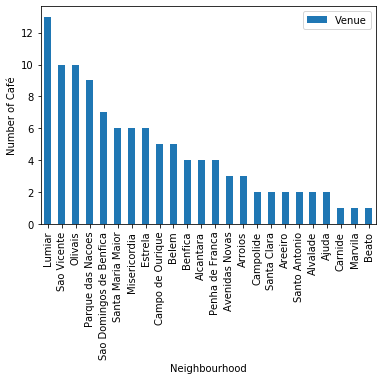

In [25]:
ax = lisbon_venues_coffee_group.sort_values(by="Venue", ascending=False).plot(x="Neighbourhood", y="Venue", kind="bar")
ax.set_ylabel("Number of Café")

In [26]:
lisbon_coffee = lisbon_grouped[["Neighbourhood", "Café"]]
lisbon_coffee

,Neighbourhood,Café
0,Ajuda,0.040816
1,Alcantara,0.047059
2,Alvalade,0.020000
3,Areeiro,0.020000
4,Arroios,0.030000
5,Avenidas Novas,0.030000
6,Beato,0.027778
7,Belem,0.065789
8,Benfica,0.080000
9,Campo de Ourique,0.050000


#### The we use _k means_ to create clusters for the category but first we need to find the optimal K. For that we use _Elbow Method_

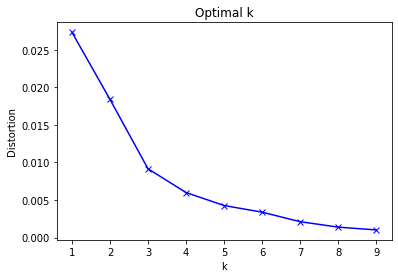

In [27]:
# try with 10 different values of k to find the best one
Ks = 10
distortions = []

lisbon_coffee_clustering = lisbon_coffee.drop('Neighbourhood', 1)

for k in range(1, Ks):

    # run k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0).fit(lisbon_coffee_clustering)

    # find the distortion w.r.t each k
    distortions.append(
        sum(np.min(cdist(lisbon_coffee_clustering, kmeans.cluster_centers_, 'euclidean'), axis=1))
        / lisbon_coffee_clustering.shape[0]
    )

plt.plot(range(1, Ks), distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Optimal k')
plt.show()

We can see from the plot the optimal **k** is **3**

#### Now we can create the clusters and show them in a map

In [28]:
nclusters = 3
kmeans = KMeans(n_clusters=nclusters, random_state=0).fit(lisbon_coffee_clustering)

In [29]:
df_coffee = lisbon_coffee.copy()
df_coffee["Cluster Labels"] = kmeans.labels_

# add two columns Latitude and Logitude into cafe_merged
df_coffee = df_coffee.join(lisbon_geospatial_data.set_index("Neighbourhood"), on="Neighbourhood")

# sort the table by cluster labels
df_coffee.sort_values(["Cluster Labels"], inplace=True)

df_coffee

,Neighbourhood,Café,Cluster Labels,Latitude,Longitude
1,Alcantara,0.047059,0,38.709594,-9.183390
20,Santa Maria Maior,0.060000,0,38.708307,-9.132405
19,Santa Clara,0.066667,0,38.785159,-9.152172
18,Penha de Franca,0.051948,0,38.726428,-9.120541
15,Misericordia,0.060000,0,38.705441,-9.146675
7,Belem,0.065789,0,38.696203,-9.213138
8,Benfica,0.080000,0,38.737742,-9.196365
9,Campo de Ourique,0.050000,0,38.718538,-9.165755
22,Sao Domingos de Benfica,0.070000,0,38.746447,-9.176374
12,Estrela,0.060000,0,38.703763,-9.163460


In [31]:
# create map
map_clusters = folium.Map(location=[lisbon_latitude, lisbon_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(nclusters)
ys = [i+x+(i*x)**2 for i in range(nclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(
        df_coffee['Latitude'], 
        df_coffee['Longitude'], 
        df_coffee['Neighbourhood'], 
        df_coffee['Cluster Labels']
):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Now we can merge the cluster data with the population density data

In [32]:
lisbon_population_data.head()

,Neighbourhood,Population,Area,Pop_Dens(pop/km2)
0,Ajuda,17958,2.85,6301.052632
1,Alcantara,14443,4.42,3267.647059
2,Alvalade,34217,5.33,6419.699812
3,Areeiro,21035,1.76,11951.704545
4,Arroios,33210,2.15,15446.511628


In [33]:
df_clusters = pd.merge(df_coffee, lisbon_population_data, how='left', left_on = 'Neighbourhood', right_on = 'Neighbourhood')
df_clusters

,Neighbourhood,Café,Cluster Labels,Latitude,Longitude,Population,Area,Pop_Dens(pop/km2)
0,Alcantara,0.047059,0,38.709594,-9.183390,14443,4.42,3267.647059
1,Santa Maria Maior,0.060000,0,38.708307,-9.132405,14191,1.49,9524.161074
2,Santa Clara,0.066667,0,38.785159,-9.152172,20153,3.32,6070.180723
3,Penha de Franca,0.051948,0,38.726428,-9.120541,30795,2.20,13997.727273
4,Misericordia,0.060000,0,38.705441,-9.146675,15877,1.12,14175.892857
5,Belem,0.065789,0,38.696203,-9.213138,17857,5.67,3149.382716
6,Benfica,0.080000,0,38.737742,-9.196365,41368,7.94,5210.075567
7,Campo de Ourique,0.050000,0,38.718538,-9.165755,24823,1.65,15044.242424
8,Sao Domingos de Benfica,0.070000,0,38.746447,-9.176374,33678,4.30,7832.093023
9,Estrela,0.060000,0,38.703763,-9.163460,21175,2.76,7672.101449


#### Examine Clusters

#### Cluster 0

In [34]:
df_clusters.loc[df_clusters['Cluster Labels'] == 0, df_clusters.columns[[0] + list(range(1, df_clusters.shape[1]))]]

,Neighbourhood,Café,Cluster Labels,Latitude,Longitude,Population,Area,Pop_Dens(pop/km2)
0,Alcantara,0.047059,0,38.709594,-9.183390,14443,4.42,3267.647059
1,Santa Maria Maior,0.060000,0,38.708307,-9.132405,14191,1.49,9524.161074
2,Santa Clara,0.066667,0,38.785159,-9.152172,20153,3.32,6070.180723
3,Penha de Franca,0.051948,0,38.726428,-9.120541,30795,2.20,13997.727273
4,Misericordia,0.060000,0,38.705441,-9.146675,15877,1.12,14175.892857
5,Belem,0.065789,0,38.696203,-9.213138,17857,5.67,3149.382716
6,Benfica,0.080000,0,38.737742,-9.196365,41368,7.94,5210.075567
7,Campo de Ourique,0.050000,0,38.718538,-9.165755,24823,1.65,15044.242424
8,Sao Domingos de Benfica,0.070000,0,38.746447,-9.176374,33678,4.30,7832.093023
9,Estrela,0.060000,0,38.703763,-9.163460,21175,2.76,7672.101449


#### Cluster 1

In [35]:
df_clusters.loc[df_clusters['Cluster Labels'] == 1, df_clusters.columns[[0] + list(range(1, df_clusters.shape[1]))]]

,Neighbourhood,Café,Cluster Labels,Latitude,Longitude,Population,Area,Pop_Dens(pop/km2)
10,Ajuda,0.040816,1,38.712174,-9.198653,17958,2.85,6301.052632
11,Santo Antonio,0.020000,1,38.721340,-9.148810,13601,1.50,9067.333333
12,Marvila,0.020408,1,38.747930,-9.110956,38767,6.32,6134.018987
13,Carnide,0.016667,1,38.765196,-9.186736,18989,4.03,4711.910670
14,Campolide,0.020000,1,38.731154,-9.167271,15927,2.78,5729.136691
15,Beato,0.027778,1,38.731050,-9.110095,14241,1.55,9187.741935
16,Avenidas Novas,0.030000,1,38.737460,-9.152329,21162,2.99,7077.591973
17,Arroios,0.030000,1,38.727653,-9.137942,33210,2.15,15446.511628
18,Areeiro,0.020000,1,38.741376,-9.133527,21035,1.76,11951.704545
19,Alvalade,0.020000,1,38.753884,-9.146498,34217,5.33,6419.699812


#### Cluster 2

In [36]:
df_clusters.loc[df_clusters['Cluster Labels'] == 2, df_clusters.columns[[0] + list(range(1, df_clusters.shape[1]))]]

,Neighbourhood,Café,Cluster Labels,Latitude,Longitude,Population,Area,Pop_Dens(pop/km2)
20,Olivais,0.138889,2,38.771030,-9.124652,46410,8.13,5708.487085
21,Parque das Nacoes,0.096774,2,38.774802,-9.095480,21025,5.44,3864.889706
22,Lumiar,0.141304,2,38.769791,-9.163492,37693,6.10,6179.180328
23,Sao Vicente,0.100000,2,38.716390,-9.121723,17087,1.22,14005.737705


#### Now we create a map showing the cluster and the population density using a _Clorophet Map_

In [37]:
lisbon_pol = r'lisbon_neighbourhoods.geojson' # geojson file

map_density = folium.Map(location=[lisbon_latitude, lisbon_longitude], zoom_start=11)

map_density.choropleth(
 geo_data=lisbon_pol,
 name='choropleth',
 data=df_clusters,
 columns=['Neighbourhood', 'Pop_Dens(pop/km2)'],
 key_on = 'feature.properties.Freguesia',
 fill_color='Blues',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Population density'
)
# folium.LayerControl().add_to(map_ahp)

# add clusters to the map
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(
        df_clusters['Latitude'], 
        df_clusters['Longitude'], 
        df_clusters['Neighbourhood'], 
        df_clusters['Cluster Labels']
):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_density)

map_density

## Results and Discussion <a name="results"></a>

From the results reached we can ascertain:
* _Café_ are among the top 3 venues found in almost every neighbourhood in Lisbon
* The neighbourhoods with the highest population density are in Lisbon's city center (high density = more clients)
* The city center does not have the neighbourhoods with the highest number of _Cafés_
* The highest number of _Café_ we can find in Lisbon's (present in Cluster 2) neighbourhoods are mostly in low density areas (Olivais, Parque das Nações, Lumiar) where São Vicente is the exception.

## Conclusion <a name="conclusion"></a>

Given the results achived we can say that _**Campo de Ourique**_ and _**Misericórida**_ neighbourhoods could be the most likely place to open a _Café_.
However, since the data here analised comes from different sources and is dated from different years (population density is from 2012) the results may not be the most up to date. The analisys performed could benefit from more recent data regarding the population.